## `Recurrent Neural Networks`
<center><img src="https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png"></center>

* `Importing Libraries`

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.13.0'

In [3]:
# Load IMDB Dataset; Load the data using only 10000 most frequent words and neglect other
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 12s 1us/step


In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [10]:
# Unique values in y_train & y_test
np.unique(y_train), np.unique(y_test)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [12]:
# Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:
max([max(idx) for idx in X_train])

9999

In [15]:
# Get the index of each word
word2idx = tf.keras.datasets.imdb.get_word_index()

# If you want to get text itslef
idx2word = {word2idx[word]:word for word in word2idx.keys()}

In [19]:
# We want to decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
' '.join([idx2word.get(i - 3, '?') for i in X_train[0]])  # for 1st instance

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [20]:
def reconstruct(tokens):
    """ A function to reconstruct the original text """
    return ' '.join([idx2word.get(i - 3, '?') for i in tokens])

# call the above function on another sample
reconstruct(X_train[100])

"? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was ? on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep ? the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the ? box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

In [21]:
len(X_train[0]), len(X_train[1])  # There are different lengths

(218, 189)

In [23]:
# Get max sequence lenght
max_seq_length = max([len(seq) for seq in X_train])
max_seq_length

2494

In [36]:
# some configurations
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 20
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 64

* `Padding & Truncation`

In [27]:
# Let's padd all sentences to have the same sequence length "MAX_SEQUENCE_LENGTH"
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=0)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=0)

print("X_train_padded shape:", X_train_padded.shape)
print("y_train dtype:", y_train.shape)
print()
print("X_test_padded shape:", X_test_padded.shape)
print("y_test dtype:", y_test.shape)

X_train_padded shape: (25000, 100)
y_train dtype: (25000,)

X_test_padded shape: (25000, 100)
y_test dtype: (25000,)


* `Model`

In [29]:
model = tf.keras.Sequential([

    ## RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=64),

    # Top classifier
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           5669376   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5688001 (21.70 MB)
Trainable params: 5688001 (21.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Compile and fit
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fitting
history = model.fit(X_train_padded, y_train,
                    validation_data=[X_test_padded[:5000], y_test[:5000]],
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/20
196/196 [==============================] - 34s 165ms/step - loss: 0.0767 - accuracy: 0.9715 - val_loss: 1.5782 - val_accuracy: 0.5646
Epoch 2/20
196/196 [==============================] - 28s 144ms/step - loss: 0.0623 - accuracy: 0.9763 - val_loss: 1.4093 - val_accuracy: 0.6274
Epoch 3/20
196/196 [==============================] - 27s 139ms/step - loss: 0.0532 - accuracy: 0.9801 - val_loss: 2.1220 - val_accuracy: 0.5614
Epoch 4/20
196/196 [==============================] - 28s 143ms/step - loss: 0.0302 - accuracy: 0.9901 - val_loss: 2.0134 - val_accuracy: 0.6346
Epoch 5/20
196/196 [==============================] - 25s 126ms/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 2.4387 - val_accuracy: 0.5956
Epoch 6/20
196/196 [==============================] - 25s 126ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 2.4506 - val_accuracy: 0.6134
Epoch 7/20
196/196 [==============================] - 25s 125ms/step - loss: 0.0160 - accuracy: 0.9942 - val_loss: 2.6785 - val_ac

In [44]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 6s 7ms/step - loss: 1.4333 - accuracy: 0.6288
Test Loss: 1.4332994222640991
Test Accuracy: 0.6287999749183655


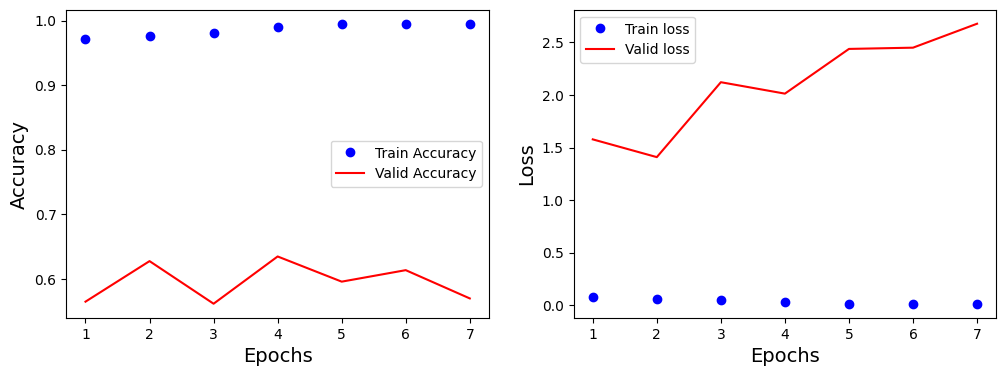

In [45]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

----

* `Bidirectional RNN`

In [46]:
model = tf.keras.models.Sequential([

    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64)),

    # FC
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           5669376   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          16512     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               24704     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5718913 (21.82 MB)
Trainable params: 571